<a href="https://colab.research.google.com/github/Valentina-Gol/9382_summer_practic_2021/blob/main/DDPG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!rm -rf gym-duckietown/
branch = "daffy" #@param ['master', 'daffy']
! git clone --branch {branch} https://github.com/duckietown/gym-duckietown
!pip install  gym-duckietown/.

!pip install pyvirtualdisplay
!pip install piglet
!apt-get install python-opengl -y
!apt install xvfb -y
!apt-get install x11-utils

! pip uninstall scipy
! pip install scipy==1.1.0


from pyvirtualdisplay import Display
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import os
def create_display():
    display = Display(visible=False, size=(1400, 900))
    d = display.start()
    if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
        !bash ../xvfb start
        %env DISPLAY=:1
    return d

display = create_display()
from gym_duckietown.envs import DuckietownEnv
from gym_duckietown.simulator import Simulator
import gym
import numpy as np
import pyglet


map_list = ["straight_road", "4way", "udem1", "small_loop", "small_loop_cw", "zigzag_dists", "loop_obstacles", "loop_pedestrians"]
seed = 1
map_name = "udem1"
draw_curve = False
draw_bbox = False
domain_rand = False
frame_skip = 1
distortion = False
camera_rand = False
dynamics_rand = False

Cloning into 'gym-duckietown'...
remote: Enumerating objects: 6045, done.
remote: Counting objects: 100% (326/326), done.
remote: Compressing objects: 100% (168/168), done.
remote: Total 6045 (delta 158), reused 254 (delta 112), pack-reused 5719
Receiving objects: 100% (6045/6045), 79.14 MiB | 20.40 MiB/s, done.
Resolving deltas: 100% (3467/3467), done.
Processing ./gym-duckietown
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for duckietown-gym-daffy: filename=duckietown_gym_daffy-6.1.16-py3-none-any.whl size=130470 sha256=136b40438c5b89a2c7acbaf1e8e70617d5851516545994b2709134783a1b9aad
  Stored in directory: /root/.cache/pip/

DEBUG:commons:version: 6.1.7 *
INFO:typing:version: 6.1.8
DEBUG:duckietown_world:duckietown-world version 6.2.24 path /usr/local/lib/python3.7/dist-packages
INFO:geometry:version: 2.0.5
DEBUG:aido_schemas:aido-protocols version 6.0.41 path /usr/local/lib/python3.7/dist-packages
INFO:nodes:version 6.2.4 path /usr/local/lib/python3.7/dist-packages pyparsing 2.4.7
DEBUG:gym-duckietown:gym-duckietown version 6.1.16 path /usr/local/lib/python3.7/dist-packages



In [2]:
import functools
import operator
import random

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Implementation of Deep Deterministic Policy Gradients (DDPG)
# Paper: https://arxiv.org/abs/1509.02971


class ActorDense(nn.Module):
    def __init__(self, state_dim, action_dim, max_action):
        super(ActorDense, self).__init__()

        state_dim = functools.reduce(operator.mul, state_dim, 1)

        self.l1 = nn.Linear(state_dim, 400)
        self.l2 = nn.Linear(400, 300)
        self.l3 = nn.Linear(300, action_dim)

        self.max_action = max_action

        self.tanh = nn.Tanh()

    def forward(self, x):
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        x = self.max_action * self.tanh(self.l3(x))
        return x


class ActorCNN(nn.Module):
    def __init__(self, action_dim, max_action):
        super(ActorCNN, self).__init__()

        # ONLY TRU IN CASE OF DUCKIETOWN:
        flat_size = 32 * 9 * 14

        self.lr = nn.LeakyReLU()
        self.tanh = nn.Tanh()
        self.sigm = nn.Sigmoid()

        self.conv1 = nn.Conv2d(3, 32, 8, stride=2)
        self.conv2 = nn.Conv2d(32, 32, 4, stride=2)
        self.conv3 = nn.Conv2d(32, 32, 4, stride=2)
        self.conv4 = nn.Conv2d(32, 32, 4, stride=1)

        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(32)
        self.bn3 = nn.BatchNorm2d(32)
        self.bn4 = nn.BatchNorm2d(32)

        self.dropout = nn.Dropout(0.5)

        self.lin1 = nn.Linear(flat_size, 512)
        self.lin2 = nn.Linear(512, action_dim)

        self.max_action = max_action

    def forward(self, x):
        x = self.bn1(self.lr(self.conv1(x)))
        x = self.bn2(self.lr(self.conv2(x)))
        x = self.bn3(self.lr(self.conv3(x)))
        x = self.bn4(self.lr(self.conv4(x)))
        x = x.reshape(x.size(0), -1)  # flatten
        x = self.dropout(x)
        x = self.lr(self.lin1(x))

        # this is the vanilla implementation
        # but we're using a slightly different one
        # x = self.max_action * self.tanh(self.lin2(x))

        # because we don't want our duckie to go backwards
        x = self.lin2(x)
        x[:, 0] = self.max_action * self.sigm(x[:, 0])  # because we don't want the duckie to go backwards
        x[:, 1] = self.tanh(x[:, 1])

        return x


class CriticDense(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(CriticDense, self).__init__()

        state_dim = functools.reduce(operator.mul, state_dim, 1)

        self.l1 = nn.Linear(state_dim, 400)
        self.l2 = nn.Linear(400 + action_dim, 300)
        self.l3 = nn.Linear(300, 1)

    def forward(self, x, u):
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(torch.cat([x, u], 1)))
        x = self.l3(x)
        return x


class CriticCNN(nn.Module):
    def __init__(self, action_dim):
        super(CriticCNN, self).__init__()

        flat_size = 32 * 9 * 14

        self.lr = nn.LeakyReLU()

        self.conv1 = nn.Conv2d(3, 32, 8, stride=2)
        self.conv2 = nn.Conv2d(32, 32, 4, stride=2)
        self.conv3 = nn.Conv2d(32, 32, 4, stride=2)
        self.conv4 = nn.Conv2d(32, 32, 4, stride=1)

        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(32)
        self.bn3 = nn.BatchNorm2d(32)
        self.bn4 = nn.BatchNorm2d(32)

        self.dropout = nn.Dropout(0.5)

        self.lin1 = nn.Linear(flat_size, 256)
        self.lin2 = nn.Linear(256 + action_dim, 128)
        self.lin3 = nn.Linear(128, 1)

    def forward(self, states, actions):
        x = self.bn1(self.lr(self.conv1(states)))
        x = self.bn2(self.lr(self.conv2(x)))
        x = self.bn3(self.lr(self.conv3(x)))
        x = self.bn4(self.lr(self.conv4(x)))
        x = x.reshape(x.size(0), -1)  # flatten
        x = self.lr(self.lin1(x))
        x = self.lr(self.lin2(torch.cat([x, actions], 1)))  # c
        x = self.lin3(x)

        return x


class DDPG(object):
    def __init__(self, state_dim, action_dim, max_action, net_type):
        super(DDPG, self).__init__()
        print("Starting DDPG init")
        assert net_type in ["cnn", "dense"]

        self.state_dim = state_dim

        if net_type == "dense":
            self.flat = True
            self.actor = ActorDense(state_dim, action_dim, max_action).to(device)
            self.actor_target = ActorDense(state_dim, action_dim, max_action).to(device)
        else:
            self.flat = False
            self.actor = ActorCNN(action_dim, max_action).to(device)
            self.actor_target = ActorCNN(action_dim, max_action).to(device)

        print("Initialized Actor")
        self.actor_target.load_state_dict(self.actor.state_dict())
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=1e-4)
        print("Initialized Target+Opt [Actor]")
        if net_type == "dense":
            self.critic = CriticDense(state_dim, action_dim).to(device)
            self.critic_target = CriticDense(state_dim, action_dim).to(device)
        else:
            self.critic = CriticCNN(action_dim).to(device)
            self.critic_target = CriticCNN(action_dim).to(device)
        print("Initialized Critic")
        self.critic_target.load_state_dict(self.critic.state_dict())
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters())
        print("Initialized Target+Opt [Critic]")

    def predict(self, state):

        # just making sure the state has the correct format, otherwise the prediction doesn't work
        assert state.shape[0] == 3

        if self.flat:
            state = torch.FloatTensor(state.reshape(1, -1)).to(device)
        else:
            state = torch.FloatTensor(np.expand_dims(state, axis=0)).to(device)
        return self.actor(state).cpu().data.numpy().flatten()

    def train(self, replay_buffer, iterations, batch_size=64, discount=0.99, tau=0.001):
        print('Training!!!')

        for it in range(iterations):

            # Sample replay buffer
            sample = replay_buffer.sample(batch_size, flat=self.flat)
            state = torch.FloatTensor(sample["state"]).to(device)
            action = torch.FloatTensor(sample["action"]).to(device)
            next_state = torch.FloatTensor(sample["next_state"]).to(device)
            done = torch.FloatTensor(1 - sample["done"]).to(device)
            reward = torch.FloatTensor(sample["reward"]).to(device)

            # Compute the target Q value
            target_Q = self.critic_target(next_state, self.actor_target(next_state))
            target_Q = reward + (done * discount * target_Q).detach()

            # Get current Q estimate
            current_Q = self.critic(state, action)

            # Compute critic loss
            critic_loss = F.mse_loss(current_Q, target_Q)

            # Optimize the critic
            self.critic_optimizer.zero_grad()
            critic_loss.backward()
            self.critic_optimizer.step()

            # Compute actor loss
            actor_loss = -self.critic(state, self.actor(state)).mean()

            # Optimize the actor
            self.actor_optimizer.zero_grad()
            actor_loss.backward()
            self.actor_optimizer.step()

            # Update the frozen target models
            for param, target_param in zip(self.critic.parameters(), self.critic_target.parameters()):
                target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)

            for param, target_param in zip(self.actor.parameters(), self.actor_target.parameters()):
                target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)

    def save(self, filename, directory):
        print("Saving to {}/{}_[actor|critic].pth".format(directory, filename))
        torch.save(self.actor.state_dict(), "{}/{}_actor.pth".format(directory, filename))
        print("Saved Actor")
        torch.save(self.critic.state_dict(), "{}/{}_critic.pth".format(directory, filename))
        print("Saved Critic")

    def load(self, filename, directory):
        self.actor.load_state_dict(
            torch.load("{}/{}_actor.pth".format(directory, filename), map_location=device)
        )
        self.critic.load_state_dict(
            torch.load("{}/{}_critic.pth".format(directory, filename), map_location=device)
        )


def seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)


# Code based on:
# https://github.com/openai/baselines/blob/master/baselines/deepq/replay_buffer.py

# Simple replay buffer
class ReplayBuffer(object):
    def __init__(self, max_size):
        self.storage = []
        self.max_size = max_size

    # Expects tuples of (state, next_state, action, reward)
    def add(self, state, next_state, action, reward):
        if len(self.storage) < self.max_size:
            self.storage.append((state, next_state, action, reward))
        else:
            # Remove random element in the memory beforea adding a new one
            self.storage.pop(random.randrange(len(self.storage)))
            self.storage.append((state, next_state, action, reward))

    def sample(self, batch_size=100, flat=True):
        ind = np.random.randint(0, len(self.storage), size=batch_size)
        states, next_states, actions, rewards= [], [], [], []

        for i in ind:
            state, next_state, action, reward= self.storage[i]

            if flat:
                states.append(np.array(state, copy=False).flatten())
                next_states.append(np.array(next_state, copy=False).flatten())
            else:
                states.append(np.array(state, copy=False))
                next_states.append(np.array(next_state, copy=False))
            actions.append(np.array(action, copy=False))
            rewards.append(np.array(reward, copy=False))

        # state_sample, action_sample, next_state_sample, reward_sample, done_sample
        return {
            "state": np.stack(states),
            "next_state": np.stack(next_states),
            "action": np.stack(actions),
            "reward": np.stack(rewards).reshape(-1, 1),
        }

def evaluate_policy(env, policy, eval_episodes=10, max_timesteps=50):
    from IPython import display
    avg_reward = 0.0
    img = plt.imshow(env.render(mode='rgb_array'))
    for _ in range(eval_episodes):
        obs = env.reset()
        done = False
        step = 0
        while not done and step < max_timesteps:
            action = policy.predict(np.array(obs))
            img.set_data(env.render(mode='rgb_array')) 
            plt.axis('off')
            display.display(plt.gcf())
            display.clear_output(wait=True)
            
            obs, reward, done, _ = env.step(action)
            print(action, reward)
            avg_reward += reward
            step += 1
    avg_reward /= eval_episodes
    return avg_reward

import gym
from gym import spaces
import numpy as np

from gym_duckietown.simulator import Simulator


class MotionBlurWrapper(Simulator):
    def __init__(self, env=None):
        Simulator.__init__(self)
        self.env = env
        self.frame_skip = 3
        self.env.delta_time = self.env.delta_time / self.frame_skip

    def step(self, action: np.ndarray):
        action = np.clip(action, -1, 1)
        # Actions could be a Python list
        action = np.array(action)
        motion_blur_window = []
        for _ in range(self.frame_skip):
            obs = self.env.render_obs()
            motion_blur_window.append(obs)
            self.env.update_physics(action)

        # Generate the current camera image

        obs = self.env.render_obs()
        motion_blur_window.append(obs)
        obs = np.average(motion_blur_window, axis=0, weights=[0.8, 0.15, 0.04, 0.01])

        misc = self.env.get_agent_info()

        d = self.env._compute_done_reward()
        misc["Simulator"]["msg"] = d.done_why

        return obs, d.reward, d.done, misc


class ResizeWrapper(gym.ObservationWrapper):
    def __init__(self, env=None, shape=(120, 160, 3)):
        super(ResizeWrapper, self).__init__(env)
        self.observation_space.shape = shape
        self.observation_space = spaces.Box(
            self.observation_space.low[0, 0, 0],
            self.observation_space.high[0, 0, 0],
            shape,
            dtype=self.observation_space.dtype,
        )
        self.shape = shape

    def observation(self, observation):
        #from PIL import image
        #np.array(Image.fromarray(observation).resize(160, 120))
        from scipy.misc import imresize

        return imresize(observation, self.shape)


class NormalizeWrapper(gym.ObservationWrapper):
    def __init__(self, env=None):
        super(NormalizeWrapper, self).__init__(env)
        self.obs_lo = self.observation_space.low[0, 0, 0]
        self.obs_hi = self.observation_space.high[0, 0, 0]
        obs_shape = self.observation_space.shape
        self.observation_space = spaces.Box(0.0, 1.0, obs_shape, dtype=np.float32)

    def observation(self, obs):
        if self.obs_lo == 0.0 and self.obs_hi == 1.0:
            return obs
        else:
            return (obs - self.obs_lo) / (self.obs_hi - self.obs_lo)


class ImgWrapper(gym.ObservationWrapper):
    def __init__(self, env=None):
        super(ImgWrapper, self).__init__(env)
        obs_shape = self.observation_space.shape
        self.observation_space = spaces.Box(
            self.observation_space.low[0, 0, 0],
            self.observation_space.high[0, 0, 0],
            [obs_shape[2], obs_shape[0], obs_shape[1]],
            dtype=self.observation_space.dtype,
        )

    def observation(self, observation):
        return observation.transpose(2, 0, 1)


class DtRewardWrapper(gym.RewardWrapper):
    def __init__(self, env):
        super(DtRewardWrapper, self).__init__(env)

    def reward(self, reward):
        if reward == -1000:
            reward = -10
        elif reward > 0:
            reward += 10
        else:
            reward += 2

        return reward


# this is needed because at max speed the duckie can't turn anymore
class ActionWrapper(gym.ActionWrapper):
    def __init__(self, env):
        super(ActionWrapper, self).__init__(env)

    def action(self, action):
        action_ = [action[0] * 0.8, action[1]]
        return action_        

KeyboardInterrupt: ignored

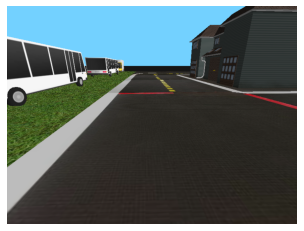

In [4]:
import ast
import argparse
import logging

import os
import numpy as np
from IPython import display

# Duckietown Specific
#from reinforcement.pytorch.ddpg import DDPG
#from reinforcement.pytorch.utils import seed, evaluate_policy, ReplayBuffer
#from utils.env import launch_env
#from utils.wrappers import NormalizeWrapper, ImgWrapper, DtRewardWrapper, ActionWrapper, ResizeWrapper

logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)

map_list = ["straight_road", "4way", "udem1", "small_loop", "small_loop_cw", "zigzag_dists", "loop_obstacles", "loop_pedestrians"]
seed = 123
map_name = "udem1"
draw_curve = False
draw_bbox = False
domain_rand = False
frame_skip = 1
distortion = False
camera_rand = False
dynamics_rand = False


def _train():

    start_timesteps = 100
    eval_freq = 5e3
    max_timesteps = 200
    save_models = False
    expl_noise = 0.1
    batch_size = 32
    discount = 0.99
    tau = 0.005
    policy_noise = 0.2 
    noise_clip = 0.5
    policy_freq = 2
    env_timesteps = 50
    replay_buffer_max_size = 100
    model_dir = ""
    

   # if not os.path.exists("./results"):
    #    os.makedirs("./results")
    #if not os.path.exists(args.model_dir):
     #   os.makedirs(args.model_dir)

    # Launch the env with our helper function
    #env = launch_env()
    env = DuckietownEnv(
          seed=seed,
          map_name=map_name,
          draw_curve=draw_curve,
          draw_bbox=draw_bbox,
          domain_rand=domain_rand,
          frame_skip=frame_skip,
          distortion=distortion,
          camera_rand=camera_rand,
          dynamics_rand=dynamics_rand,
      )


    print("Initialized environment")

    # Wrappers
    env = ResizeWrapper(env)
    #env = NormalizeWrapper(env)
    env = ImgWrapper(env)  # to make the images from 160x120x3 into 3x160x120
    env = ActionWrapper(env)
    #env = DtRewardWrapper(env)
    print("Initialized Wrappers")

    # Set seeds
    #seed(seed)
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

    state_dim = env.observation_space.shape
    #print('state_dim', state_dim)
    action_dim = env.action_space.shape[0]
    #print('action_dim', action_dim)
    max_action = float(env.action_space.high[0])
    #print('env_dim', max_action)

    # Initialize policy
    policy = DDPG(state_dim, action_dim, max_action, net_type="cnn")
    replay_buffer = ReplayBuffer(replay_buffer_max_size)
    print("Initialized DDPG")

    # Evaluate untrained policy

    #evaluations = []
    print("evaluations")
    total_timesteps = 0
    #timesteps_since_eval = 0
    #episode_num = 0
    #done = True
    #episode_reward = None
    #env_counter = 0
    reward = 0
    #episode_timesteps = 0
    T = 100


    img = plt.imshow(env.render(mode='rgb_array'))

    #initial replay buffer
    while len(replay_buffer.storage) < replay_buffer_max_size:
        obs = env.reset()
        for i in range(int(replay_buffer_max_size / 10)):
            action = policy.predict(np.array(obs))
            img.set_data(env.render(mode='rgb_array')) 
            plt.axis('off')
            display.display(plt.gcf())
            display.clear_output(wait=True)  
            print("step_count = %s, reward=%.3f" % (env.unwrapped.step_count, reward))          
            new_obs, reward, done, _ = env.step(action)
            replay_buffer.add(obs, new_obs, action, reward)
            obs = new_obs


    #max timesteps M
    for total_timesteps in range(max_timesteps):
        print(f"Epoch {total_timesteps}")
        #recieve initial observation state
        obs = env.reset()
        for it in range(T):
            #select action
            action = policy.predict(np.array(obs))
            print('action', action)
            #if expl_noise != 0:
            #    action = (action + np.random.normal(0, expl_noise, size=env.action_space.shape[0])).clip(
            #        env.action_space.low, env.action_space.high
            #    )
            print('noize action', action)    
            #execute action
            new_obs, reward, done, _ = env.step(action)
            #store transition
            replay_buffer.add(obs, new_obs, action, reward)

            # Sample random minibatch from replay buffer
            sample = replay_buffer.sample(batch_size, flat=policy.flat)
            state = torch.FloatTensor(sample["state"]).to(device)
            action = torch.FloatTensor(sample["action"]).to(device)
            next_state = torch.FloatTensor(sample["next_state"]).to(device)
            reward = torch.FloatTensor(sample["reward"]).to(device)

            # Compute the target Q value
            target_Q = policy.critic_target(next_state, policy.actor_target(next_state))
            target_Q = reward + (discount * target_Q).detach()

            # Get current Q estimate
            current_Q = policy.critic(state, action)

            # Compute critic loss
            critic_loss = F.mse_loss(current_Q, target_Q)

            # Update the critic
            policy.critic_optimizer.zero_grad()
            critic_loss.backward()
            policy.critic_optimizer.step()

            # Compute actor loss
            actor_loss = -policy.critic(state, policy.actor(state)).mean()

            # Update the actor
            policy.actor_optimizer.zero_grad()
            actor_loss.backward()
            policy.actor_optimizer.step()

            # Update the frozen target models
            for param, target_param in zip(policy.critic.parameters(), policy.critic_target.parameters()):
                target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)

            for param, target_param in zip(policy.actor.parameters(), policy.actor_target.parameters()):
                target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)
        
        #evaluate policy    
        import time
        print("Evaluation")
        time.sleep(1)    
        evaluate_policy(env, policy)  
        time.sleep(1)   

        #save checkpoint   
        if save_models:
            policy.save(file_name="ddpg", directory=model_dir)

if __name__ == "__main__":
    #parser = argparse.ArgumentParser()
    _train()    


In [3]:
import ast
import argparse
import logging

import os
import numpy as np

# Duckietown Specific
from reinforcement.pytorch.ddpg import DDPG
from utils.env import launch_env
from utils.wrappers import NormalizeWrapper, ImgWrapper, DtRewardWrapper, ActionWrapper, ResizeWrapper


def _enjoy():
    # Launch the env with our helper function
    env = launch_env()
    print("Initialized environment")

    # Wrappers
    env = ResizeWrapper(env)
    env = NormalizeWrapper(env)
    env = ImgWrapper(env)  # to make the images from 160x120x3 into 3x160x120
    env = ActionWrapper(env)
    env = DtRewardWrapper(env)
    print("Initialized Wrappers")

    state_dim = env.observation_space.shape
    action_dim = env.action_space.shape[0]
    max_action = float(env.action_space.high[0])

    # Initialize policy
    policy = DDPG(state_dim, action_dim, max_action, net_type="cnn")
    policy.load(filename="ddpg", directory="reinforcement/pytorch/models/")

    obs = env.reset()
    done = False

    while True:
        while not done:
            action = policy.predict(np.array(obs))
            # Perform action
            obs, reward, done, _ = env.step(action)
            env.render()
        done = False
        obs = env.reset()


if __name__ == "__main__":
    _enjoy()

ModuleNotFoundError: ignored